# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2024/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2024/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(p):
    return -np.sum(p * np.log(p))

p_k1 = 0.8
p_k2 = 0.2
probabilities = np.array([p_k1, p_k2])
print(round(entropy(probabilities), 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def gini(p):
    return np.sum(p * (1 - p))

p_k1 = 0.8
p_k2 = 0.2
probabilities_Rm = np.array([p_k1, p_k2])
H_Rm = gini(probabilities_Rm)
p_k1_l = 1
p_k2_l = 0
probabilities_Rl = np.array([p_k1_l, p_k2_l])
H_Rl = gini(probabilities_Rl)
p_k1_r = 0
p_k2_r = 1
probabilities_Rr = np.array([p_k1_r, p_k2_r])
H_Rr = gini(probabilities_Rr)
print(round(H_Rm - 0.8 * H_Rl - 0.2 * H_Rr, 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
x = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(np.mean(x))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def gini_impurity(y: np.ndarray) -> float:
    m = len(y)
    if m == 0:
        return 0
    class_counts = np.bincount(y)
    p = class_counts / m
    return np.sum(p * (1 - p))

def variance(y: np.ndarray) -> float:
    return np.var(y)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    if isinstance(feature_vector, pd.DataFrame):
        feature_vector = feature_vector.values
    if isinstance(target_vector, pd.Series):
        target_vector = target_vector.values

    m = len(feature_vector)
    best_criterion = float('inf')
    best_threshold = None
    thresholds = []
    criteria = []

    feature_values = feature_vector.flatten()
    if feature_type == "real":
        sorted_indices = np.argsort(feature_values)
        feature_values = feature_values[sorted_indices]
        target_sorted = target_vector[sorted_indices]

        possible_thresholds = (feature_values[:-1] + feature_values[1:]) / 2
        unique_thresholds = np.unique(possible_thresholds)
        
        left_masks = feature_values[:, np.newaxis] <= unique_thresholds
        right_masks = ~left_masks

        left_counts = left_masks.sum(axis=0)
        right_counts = right_masks.sum(axis=0)

        valid_thresholds_mask = (left_counts > 0) & (right_counts > 0)
        valid_thresholds = unique_thresholds[valid_thresholds_mask]
        
        left_masks = left_masks[:, valid_thresholds_mask]
        right_masks = right_masks[:, valid_thresholds_mask]

        if left_masks.shape[1] == 0 or right_masks.shape[1] == 0:
            return np.array([]), np.array([]), None, float('inf')

        left_criteria = np.apply_along_axis(lambda m: gini_impurity(target_sorted[m]) if task == "classification" else variance(target_sorted[m]), 0, left_masks)
        right_criteria = np.apply_along_axis(lambda m: gini_impurity(target_sorted[m]) if task == "classification" else variance(target_sorted[m]), 0, right_masks)

        left_ratios = left_counts[valid_thresholds_mask] / m
        right_ratios = right_counts[valid_thresholds_mask] / m

        criteria = left_ratios * left_criteria + right_ratios * right_criteria
        thresholds = valid_thresholds

        best_index = np.argmin(criteria)
        best_threshold = thresholds[best_index]
        best_criterion = criteria[best_index]
    
    elif feature_type == "categorical":
        unique_values = np.unique(feature_values)
        
        left_masks = feature_values[:, np.newaxis] == unique_values
        right_masks = ~left_masks

        left_counts = left_masks.sum(axis=0)
        right_counts = right_masks.sum(axis=0)

        valid_thresholds_mask = (left_counts > 0) & (right_counts > 0)
        valid_thresholds = unique_values[valid_thresholds_mask]
        
        left_masks = left_masks[:, valid_thresholds_mask]
        right_masks = right_masks[:, valid_thresholds_mask]

        if left_masks.shape[1] == 0 or right_masks.shape[1] == 0:
            return np.array([]), np.array([]), None, float('inf')

        left_targets = target_vector[:, np.newaxis] * left_masks
        right_targets = target_vector[:, np.newaxis] * right_masks

        left_criteria = np.apply_along_axis(lambda col: gini_impurity(col[col != 0]) if task == "classification" else variance(col[col != 0]), 0, left_targets)
        right_criteria = np.apply_along_axis(lambda col: gini_impurity(col[col != 0]) if task == "classification" else variance(col[col != 0]), 0, right_targets)

        left_ratios = left_counts[valid_thresholds_mask] / m
        right_ratios = right_counts[valid_thresholds_mask] / m

        criteria = left_ratios * left_criteria + right_ratios * right_criteria
        thresholds = valid_thresholds

        best_index = np.argmin(criteria)
        best_threshold = thresholds[best_index]
        best_criterion = criteria[best_index]
    
    thresholds = np.array(thresholds)
    criteria = np.array(criteria)

    return thresholds, criteria, best_threshold, best_criterion


Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

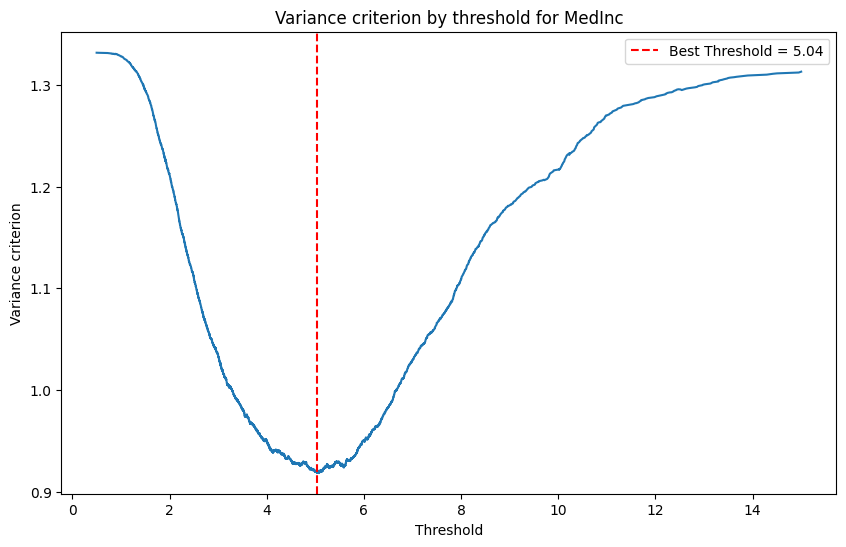

Best Threshold: 5.03515
Best criterion value: 0.9187989138801309


In [10]:
feature_vector = X[['MedInc']].values

thresholds, criteria, best_threshold, best_criterion = find_best_split(feature_vector, y, task="regression", feature_type="real")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, criteria)
plt.xlabel('Threshold')
plt.ylabel('Variance criterion')
plt.title('Variance criterion by threshold for MedInc')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.legend()
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best criterion value: {best_criterion}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
categorical_features = ['Latitude', 'Longitude']

# Инициализация переменных для хранения лучшего результата
best_feature = None
best_threshold = None
best_criterion = float('inf')

# Перебор всех признаков
for feature in X.columns:
    feature_vector = X[[feature]].values
    if feature in categorical_features:
        feature_type = "categorical"
    else:
        feature_type = "real"
        
    thresholds, criteria, threshold, criterion = find_best_split(feature_vector, y, task="regression", feature_type=feature_type)
    
    if criterion < best_criterion:
        best_criterion = criterion
        best_threshold = threshold
        best_feature = feature

print(f"Лучший признак: {best_feature}")
print(f"Лучший порог: {best_threshold}")
print(f"Лучшее значение критерия: {best_criterion}")

Лучший признак: MedInc
Лучший порог: 5.03515
Лучшее значение критерия: 0.9187989138801309


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        
        self._feature_types = feature_types
        
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        self._feature_importances = {}

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            node["y"] = sub_y 
            return

        if sub_X.shape[1] == 0:
            node["type"] = "terminal"
            node["class"] = np.bincount(sub_y).argmax()
            node["y"] = sub_y 
            return

        feature_best, threshold_best, gini_best = None, None, None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini < gini_best:
                feature_best, threshold_best, gini_best = feature, threshold, gini

        if gini_best is None:
            node["type"] = "terminal"
            node["class"] = np.bincount(sub_y).argmax()
            node["y"] = sub_y 
            return

        node["type"] = "nonterminal"
        node["feature"] = feature_best
        node["threshold"] = threshold_best
        node["y"] = sub_y 

        feature_vector = sub_X[:, feature_best]
        if self._feature_types[feature_best] == "real":
            split = feature_vector <= threshold_best
        else:
            split = feature_vector == threshold_best

        node["left_indices"] = np.where(split)[0]
        node["right_indices"] = np.where(~split)[0]

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]
        if self._feature_types[node["feature"]] == "real":
            if x[node["feature"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[node["feature"]] == node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def predict(self, X):
        return np.array([self._predict_node(x, self._tree) for x in X])
    
    def _handle_missing_values(self, X): #обработка пропущенных значений
        for feature_idx, feature_type in enumerate(self._feature_types):
            if feature_type == "real":
                col_values = X[:, feature_idx]
                col_mean = np.nanmean(col_values)
                X[np.isnan(col_values), feature_idx] = col_mean #для вещественных переменных заменяем на среднее
            elif feature_type == "categorical":
                col_values = X[:, feature_idx]
                col_mode = stats.mode(col_values, nan_policy='omit')[0][0]
                X[np.isnan(col_values), feature_idx] = col_mode #для вещественных переменных заменяем на моду
        return X
    
    def _calculate_gini_impurity(self, y):
        return gini_impurity(y)

    def _calculate_feature_importance(self, node, feature_importance):
        if node["type"] == "terminal":
            return

        y = node["y"]
        parent_gini = self._calculate_gini_impurity(y)

        left_indices = node["left_indices"]
        right_indices = node["right_indices"]

        left_y = y[left_indices]
        right_y = y[right_indices]

        left_gini = self._calculate_gini_impurity(left_y)
        right_gini = self._calculate_gini_impurity(right_y)

        impurity_decrease = parent_gini - (len(left_y) / len(y)) * left_gini - (len(right_y) / len(y)) * right_gini
        
        feature_importance[node["feature"]] += impurity_decrease

        self._calculate_feature_importance(node["left_child"], feature_importance)
        self._calculate_feature_importance(node["right_child"], feature_importance)

    def feature_importance(self):
        feature_importance = np.zeros(len(self._feature_types))
        self._calculate_feature_importance(self._tree, feature_importance)
        return feature_importance / feature_importance.sum()

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
data_stud = pd.read_csv('https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/students.csv')
data_stud

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...,...
253,253,0.61,0.78,0.69,0.92,0.58,1
254,254,0.78,0.61,0.71,0.19,0.60,1
255,255,0.54,0.82,0.71,0.29,0.77,1
256,256,0.50,0.75,0.81,0.61,0.26,1


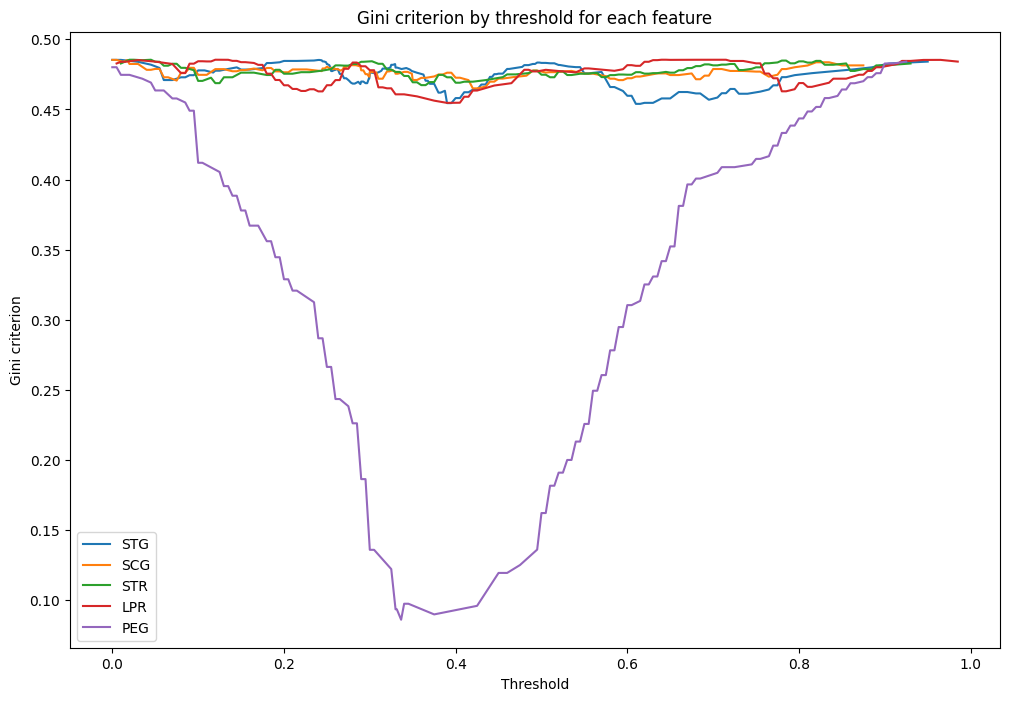

In [14]:
X_stud = data_stud.iloc[:, :-1].values
y_stud = data_stud.iloc[:, -1].values

plt.figure(figsize=(12, 8))
for i, feature in enumerate(data_stud.columns[1:-1]):
    feature_vector = X_stud[:, i+1]
    thresholds, criteria, _, _ = find_best_split(feature_vector, y_stud, task="classification", feature_type="real")
    plt.plot(thresholds, criteria, label=feature)

plt.xlabel('Threshold')
plt.ylabel('Gini criterion')
plt.title('Gini criterion by threshold for each feature')
plt.legend()
plt.show()


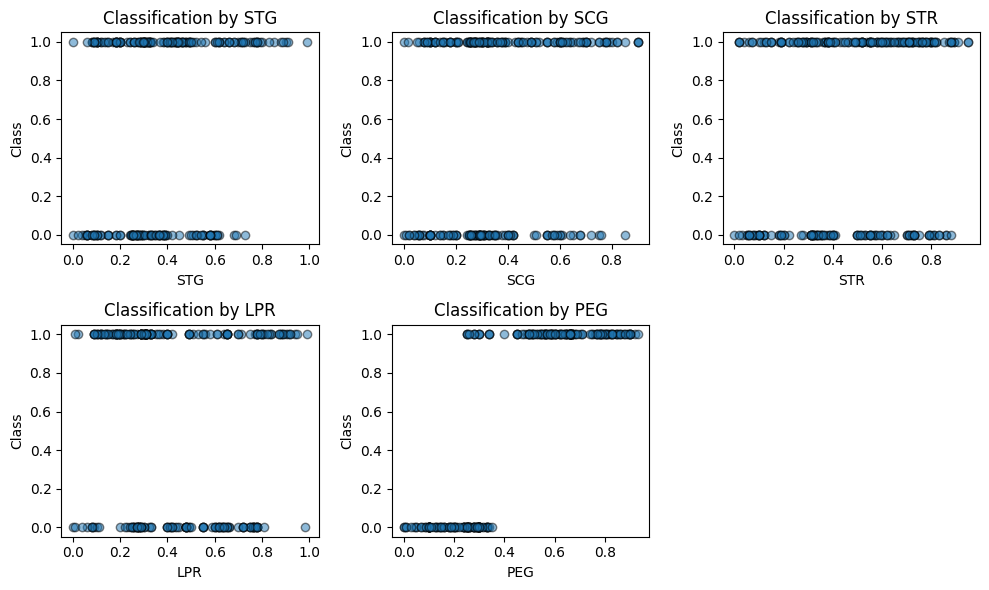

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()

for i, feature in enumerate(data_stud.columns[1:-1]):
    axes[i].scatter(data_stud[feature], y_stud, alpha=0.5, edgecolors='k')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Class')
    axes[i].set_title(f'Classification by {feature}')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [16]:
best_feature = None
best_threshold = None
min_gini = float('inf')

for i, feature in enumerate(data_stud.columns[:-1]):
    feature_vector = X_stud[:, i]
    thresholds, criteria, threshold, gini = find_best_split(feature_vector, y_stud, task="classification", feature_type="real")
    
    if gini < min_gini:
        min_gini = gini
        best_feature = feature
        best_threshold = threshold

print(f"Лучший признак: {best_feature}")
print(f"Лучший порог: {best_threshold}")
print(f"Минимальное значение критерия Джини: {min_gini}")

Лучший признак: PEG
Лучший порог: 0.3365
Минимальное значение критерия Джини: 0.08606560274912148


Первое деление надо делать по признаку PEG. Визуально тоже так получается.

Для хороших признаков кривая должна иметь четкий минимум, который покажет порог, который лучше всего разделяет класы. Что-то наподобие параболы ветвями вверх

У признаков, по которым деление практически невозможно, кривая не будет иметь минимумов и будет везде примерно одинаковой и будут высокие значения Джини

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'

data_mushrooms = pd.read_csv(url, header=None)

label_encoders = {}
for column in data_mushrooms.columns:
    le = LabelEncoder()
    data_mushrooms[column] = le.fit_transform(data_mushrooms[column])
    label_encoders[column] = le

X_mushrooms = data_mushrooms.iloc[:, 1:].values
y_mushrooms = data_mushrooms.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X_mushrooms, y_mushrooms, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X_mushrooms.shape[1]

tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9970457902511078


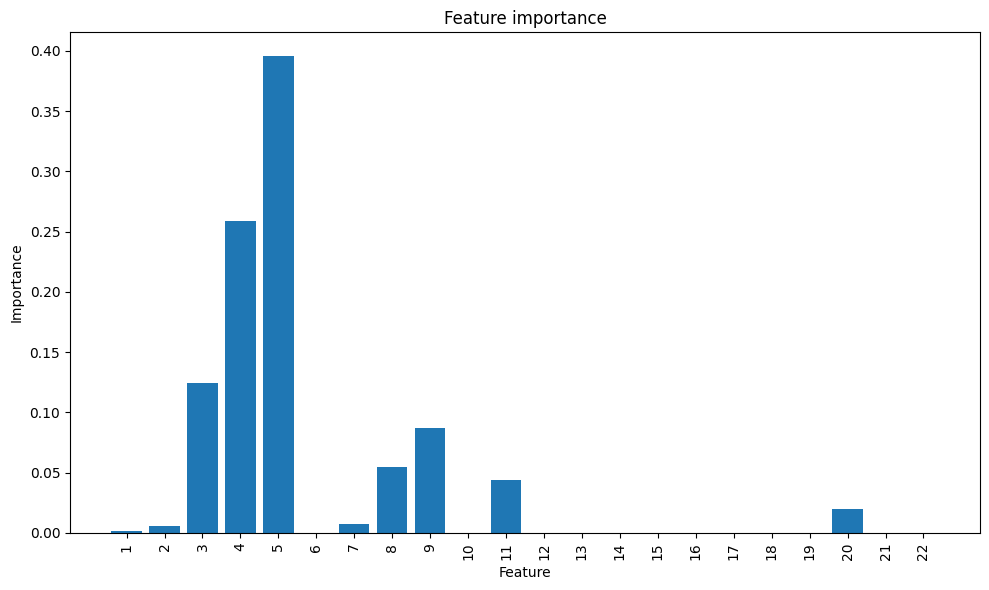

In [18]:
importances = tree.feature_importance()

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), data_mushrooms.columns[1:], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importance')
plt.tight_layout()
plt.show()

Получается, код для вычисления важности признаков работает!

In [19]:
data_mushrooms

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [20]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier

In [21]:
data = pd.read_csv('https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

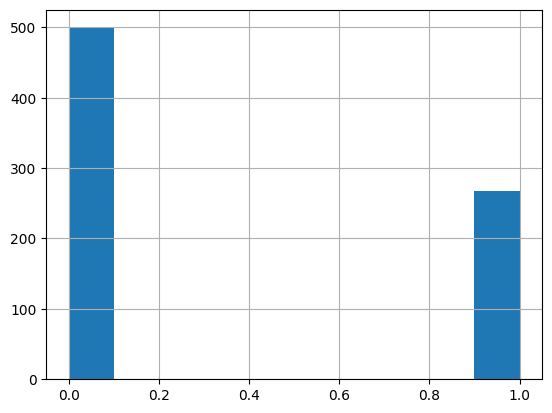

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
X = data.drop(columns='Outcome').values
y = data['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(f"Обучающая-обучающая выборка: {X_train_train.shape}, {y_train_train.shape}")
print(f"Обучающая-валидационная выборка: {X_val.shape}, {y_val.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Обучающая-обучающая выборка: (375, 8), (375,)
Обучающая-валидационная выборка: (162, 8), (162,)
Тестовая выборка: (231, 8), (231,)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [24]:
from sklearn.tree import DecisionTreeClassifier

max_depth_values = np.arange(1,15)
min_samples_leaf_values = np.arange(1,15)
best_f1_score = -1

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train_train, y_train_train)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_params = (max_depth, min_samples_leaf)

print(f"Лучшие гиперпараметры: max_depth = {best_params[0]}, min_samples_leaf = {best_params[1]}")
print(f"Лучшее значение F1: {best_f1_score}")

best_clf = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1], random_state=42)
best_clf.fit(X_train, y_train)

y_test_pred = best_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_test_pred)
precision_dt = precision_score(y_test, y_test_pred)
recall_dt = recall_score(y_test, y_test_pred)
auc_roc_dt = roc_auc_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"AUC ROC: {auc_roc_dt}")


Лучшие гиперпараметры: max_depth = 7, min_samples_leaf = 7
Лучшее значение F1: 0.7142857142857143
Accuracy: 0.696969696969697
Precision: 0.5555555555555556
Recall: 0.625
AUC ROC: 0.6800496688741722


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [25]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1], random_state=42),
    n_estimators=50,
    random_state=42
)
bagging_clf.fit(X_train, y_train)

y_test_pred_bagging = bagging_clf.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_test_pred_bagging)
precision_bagging = precision_score(y_test, y_test_pred_bagging)
recall_bagging = recall_score(y_test, y_test_pred_bagging)
auc_roc_bagging = roc_auc_score(y_test, y_test_pred_bagging)

print(f"BaggingClassifier Accuracy: {accuracy_bagging}")
print(f"BaggingClassifier Precision: {precision_bagging}")
print(f"BaggingClassifier Recall: {recall_bagging}")
print(f"BaggingClassifier AUC ROC: {auc_roc_bagging}")


BaggingClassifier Accuracy: 0.7575757575757576
BaggingClassifier Precision: 0.6463414634146342
BaggingClassifier Recall: 0.6625
BaggingClassifier AUC ROC: 0.7352235099337749


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

max_depth_values = np.arange(1, 20)
min_samples_leaf_values = np.arange(1, 20)

param_grid = {
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_leaf_values
}

rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params_rf = grid_search.best_params_
print(f"Best max_depth: {best_params_rf['max_depth']}")
print(f"Best min_samples_split: {best_params_rf['min_samples_split']}")

best_rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
best_rf_clf.fit(X_train, y_train)

y_test_pred_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_test_pred_rf)

print(f"RandomForest Accuracy: {accuracy_rf}")
print(f"RandomForest Precision: {precision_rf}")
print(f"RandomForest Recall: {recall_rf}")
print(f"RandomForest AUC ROC: {auc_roc_rf}")

print()

print(f"Decision Tree Accuracy: {accuracy_dt}")
print(f"BaggingClassifier Accuracy: {accuracy_bagging}")
print(f"RandomForest Accuracy: {accuracy_rf}")

print()

print(f"Decision Tree Precision: {precision_dt}")
print(f"BaggingClassifier Precision: {precision_bagging}")
print(f"RandomForest Precision: {precision_rf}")

print()

print(f"Decision Tree Recall: {recall_dt}")
print(f"BaggingClassifier Recall: {recall_bagging}")
print(f"RandomForest Recall: {recall_rf}")

print()

print(f"Decision Tree AUC ROC: {auc_roc_dt}")
print(f"BaggingClassifier AUC ROC: {auc_roc_bagging}")
print(f"RandomForest AUC ROC: {auc_roc_rf}")

Best max_depth: 11
Best min_samples_split: 12
RandomForest Accuracy: 0.7402597402597403
RandomForest Precision: 0.6190476190476191
RandomForest Recall: 0.65
RandomForest AUC ROC: 0.7190397350993377

Decision Tree Accuracy: 0.696969696969697
BaggingClassifier Accuracy: 0.7575757575757576
RandomForest Accuracy: 0.7402597402597403

Decision Tree Precision: 0.5555555555555556
BaggingClassifier Precision: 0.6463414634146342
RandomForest Precision: 0.6190476190476191

Decision Tree Recall: 0.625
BaggingClassifier Recall: 0.6625
RandomForest Recall: 0.65

Decision Tree AUC ROC: 0.6800496688741722
BaggingClassifier AUC ROC: 0.7352235099337749
RandomForest AUC ROC: 0.7190397350993377


Лучше всего себя показал BaggingClassifier

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

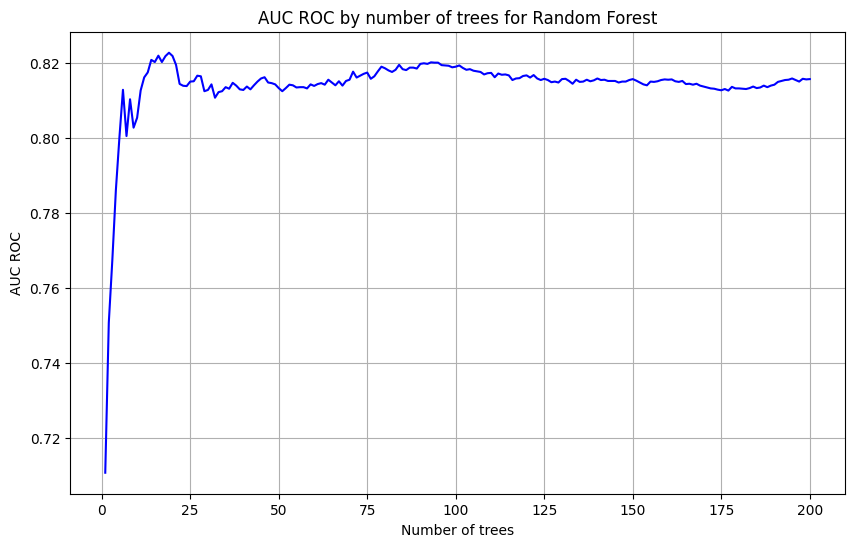

In [27]:
n_estimators_range = np.linspace(1, 200, 200, dtype=int)
auc_roc_scores = []

for n_estimators in n_estimators_range:
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=best_params_rf['max_depth'],
        min_samples_split=best_params_rf['min_samples_split'],
        random_state=42
    )
    rf_clf.fit(X_train, y_train)
    y_test_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_test_pred_rf)
    auc_roc_scores.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_roc_scores, linestyle='-', color='b')
plt.xlabel('Number of trees')
plt.ylabel('AUC ROC')
plt.title('AUC ROC by number of trees for Random Forest')
plt.grid(True)
plt.show()

Сначала AUC-ROC быстро растет, затем около n_estimators=20 значение AUC ROC достигает пика, после чего значение метрики падает, и начиная с n_estimators=30 AUC ROC всегда примерно одинаковый и меньше пикового значения. Это говорит о том, что случайный лес хорошо находит оптимальные предикаты, но потом происходит переобучение, и качество модели падает.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

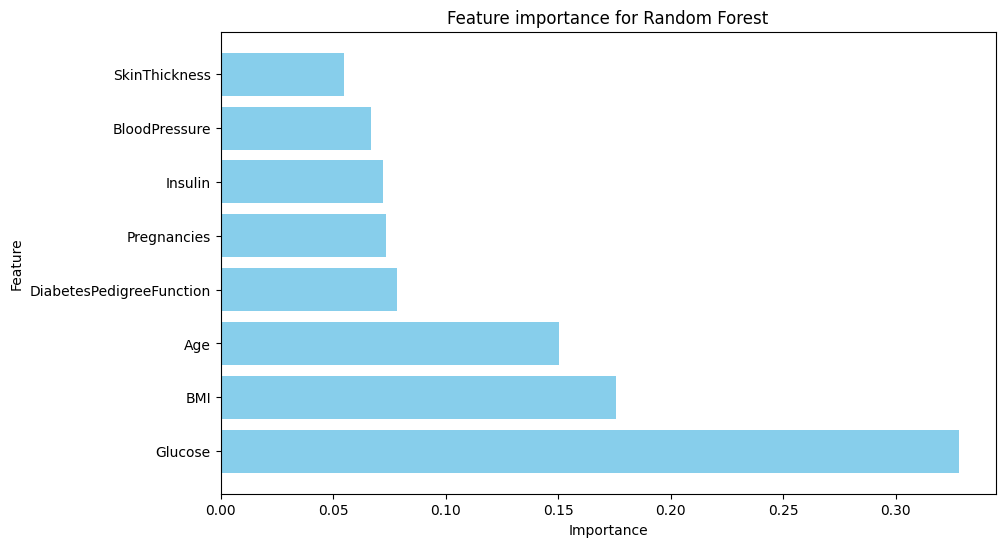

Самый важный признак - Glucose


In [28]:
best_rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
best_rf_clf.fit(X_train, y_train)

feature_importances = best_rf_clf.feature_importances_

importance_df = pd.DataFrame({'Feature': data.drop(columns='Outcome').columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance for Random Forest')
plt.show()

most_important_feature = importance_df.iloc[0]['Feature']
print(f"Самый важный признак - {most_important_feature}")